Todo: 
* add defense
* make questionable and probable 1 and everything else 0

# Cloudy With a Chance of Football
## Global Machine Learning Model (Incomplete)
<a id='header_cell'></a>
Author: Aidan O'Connor   
Date: 1 June 2021   

### Table of Contents:
- [Data Preparation](#import_and_options_cell)
    - [Import packages, read in data, set options](#import_and_options_cell)
    - [Understanding the data](#data_review_cell)
    - [Preparing the data](#scoring_models_cell)
- [Global Machine Learning Model](#global_model_cell)
    - [Model Selection](#model_selection_cell)
        - [Selecting Columns](#column_selection_cell)
        - [Selecting models to score](#model_scoring_selection_cell)
        - [Scoring selected models](#scoring_models_cell)
    - [Hyperparameter Tuning](#hyperparameter_tuning_cell)

## Data Preparation
<a id='data_prep_section_cell'></a>

### Import packages, read in data, set options
<a id='import_and_options_cell'></a>
I'll start by importing all necessary packages to import, manipulate, visualize, and create machine learning models for data.   

Then, I'll set some preferences for some of these packages.   

Finally, I'll access our sqlite3 database and bring in a series of dataframes from the tables, then merge them. I chose not to do this with a single SQL statement, since I tried this with some difficulty

In [1]:
# Packages to import and manipulate data
import sqlite3
import pandas as pd
import numpy as np

# Packages to visualize data
import matplotlib.pyplot as plt
import seaborn as sns

# Packages to create and visualize machine learning models from yellowbrick
from yellowbrick.target import ClassBalance
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import confusion_matrix

# Packages to create machine learning models from scikit-learn
from sklearn.model_selection import train_test_split as tts
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import Ridge
from sklearn.metrics import f1_score

#Evaluation toolset
from sklearn.model_selection import StratifiedKFold, cross_val_score
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ClassificationReport
from yellowbrick.features import FeatureImportances

In [2]:
# Set pandas viewing options
pd.set_option('display.max_columns', None)

# Bring in jupyter magic
%matplotlib inline

# Set matplotlib visualization styling options
plt.rcParams['figure.figsize'] = (18,7)
plt.style.use('fivethirtyeight')

In [3]:
# Read in all data from database and merge the data on player_id
conn = sqlite3.connect('../../fixtures/database/cloudy_with_a_chance_of_football.db')
cursorObj = conn.cursor()

In [4]:
cursorObj.execute("select * from SQLite_master")

tables = cursorObj.fetchall()

print("Here are the tables and indices from the main database:")
for table in tables:
        print(f"Type of database object: {table[0]}")
        print(f"Name of the database object: {table[1]}")
        print(f"Table Name: {table[2]}")
        print(f"Root page: {table[3]}")
        print(f"SQL statement: {table[4]}")

Here are the tables and indices from the main database:
Type of database object: table
Name of the database object: positions
Table Name: positions
Root page: 2
SQL statement: CREATE TABLE "positions" (
"PlayerID" INTEGER,
  "Position" TEXT
)
Type of database object: table
Name of the database object: player_dob
Table Name: player_dob
Root page: 125
SQL statement: CREATE TABLE "player_dob" (
"PlayerID" INTEGER,
  "dob" TEXT
)
Type of database object: table
Name of the database object: players
Table Name: players
Root page: 154
SQL statement: CREATE TABLE "players" (
"PlayerID" INTEGER,
  "FirstName" TEXT,
  "LastName" TEXT,
  "uniqueID" TEXT
)
Type of database object: table
Name of the database object: player_team
Table Name: player_team
Root page: 190
SQL statement: CREATE TABLE "player_team" (
"PlayerID" INTEGER,
  "week_id" TEXT,
  "Team" TEXT
)
Type of database object: table
Name of the database object: player_age
Table Name: player_age
Root page: 393
SQL statement: CREATE TABLE "p

Select all but the ```stats_regular```, ```days_since_last_game```, ```elevation_and_conference```, and ```stats_red_zone``` tables because I have not prepared that data using ```pd.shift()```

In [5]:
#cursorObj.execute(create_df_sql)
positions = pd.read_sql_query('SELECT * from positions',conn)
player_team = pd.read_sql_query('SELECT * from player_team',conn)
player_age = pd.read_sql_query('SELECT * from player_age',conn)
injury_status = pd.read_sql_query('SELECT * from injury_status',conn)
days_since_last_game = pd.read_sql_query('SELECT * from days_since_last_game',conn)
weather = pd.read_sql_query('SELECT * from weather',conn)
hours_displaced = pd.read_sql_query("""SELECT week_id,
                                    team_away_short,
                                    team_home_short,
                                    absolute_hours_displaced from hours_displaced""",conn)
stats = pd.read_sql_query('SELECT * from stats_regular',conn)
target = pd.read_sql_query('SELECT week_id,PlayerID,performance,performance_class from performance_target',conn)
elevation = pd.read_sql_query('SELECT Team,elevation from elevation_and_conference',conn)

In [6]:
df = player_team.merge(positions, how = 'left', on = 'PlayerID').drop_duplicates()

In [7]:
df = pd.merge(df, injury_status, how = 'left', left_on = ['PlayerID','week_id'], right_on = ['PlayerID','week_id'])

In [8]:
days_since_last_game = days_since_last_game.rename({'team_name':'Team'}, axis = 1)

In [9]:
df = pd.merge(df, days_since_last_game, how = 'left', left_on = ['Team','week_id'], right_on = ['Team','week_id'])

In [10]:
df = pd.merge(df, target, how = 'left', left_on = ['week_id','PlayerID'], right_on = ['week_id','PlayerID'])

In [11]:
df = pd.merge(df, hours_displaced, how = 'left', left_on = ['week_id','Team'], right_on = ['week_id','team_away_short'])

In [13]:
df = pd.merge(df, stats, how = 'left', left_on = ['PlayerID','week_id','Team'], right_on = ['PlayerID','new_week_id','Team'])

In [14]:
df.loc[df['HomeOrAway'] == 'HOME', 'absolute_hours_displaced'] = 0

In [15]:
home = df[df['HomeOrAway'] == 'HOME']
away = df[df['HomeOrAway'] == 'AWAY']

In [16]:
home = pd.merge(home, weather, how = 'left', left_on = ['week_id','Team'], right_on = ['week_id','team_home_short'])
away = pd.merge(away, weather, how = 'left', left_on = ['week_id','Team'], right_on = ['week_id','team_away_short'])

In [17]:
df = df.drop_duplicates()

In [18]:
df = pd.concat([home,away], ignore_index = True).drop(['team_home_short_y','team_away_short_y','team_away_short_x','team_home_short_x'], axis = 1)

In [19]:
season_week = []

for n in df['week_id']:
    season_week.append(n[5:])
    
df['season_week'] = season_week

In [20]:
df['week_id'][0][:4]

'2019'

In [21]:
season_year = []

for n in df['week_id']:
    season_year.append(n[:4])
    
df['season_year'] = season_year

In [22]:
df = df[pd.notnull(df['performance'])]

In [23]:
df = df[df['season_year'] != '2018']

In [24]:
df

,PlayerID,week_id,Team,Position_x,injury_status,days_since_last_game,performance,performance_class,absolute_hours_displaced,GameKey,SeasonType,Season,GameDate,Week,Opponent,HomeOrAway,Number,Name,Position_y,PositionCategory,Played,Started,PassingAttempts,PassingCompletions,PassingYards,PassingCompletionPercentage,PassingYardsPerAttempt,PassingYardsPerCompletion,PassingTouchdowns,PassingInterceptions,PassingRating,PassingLong,PassingSacks,PassingSackYards,RushingAttempts,RushingYards,RushingYardsPerAttempt,RushingTouchdowns,RushingLong,ReceivingTargets,Receptions,ReceivingYards,ReceivingYardsPerReception,ReceivingTouchdowns,ReceivingLong,Fumbles,FumblesLost,PuntReturns,PuntReturnYards,PuntReturnTouchdowns,KickReturns,KickReturnYards,KickReturnTouchdowns,SoloTackles,AssistedTackles,TacklesForLoss,Sacks,SackYards,QuarterbackHits,PassesDefended,FumblesForced,FumblesRecovered,FumbleReturnTouchdowns,Interceptions,InterceptionReturnTouchdowns,FieldGoalsAttempted,FieldGoalsMade,ExtraPointsMade,TwoPointConversionPasses,TwoPointConversionRuns,TwoPointConversionReceptions,FantasyPoints,FantasyPointsPPR,FantasyPosition,PlayerGameID,ExtraPointsAttempted,FantasyPointsFanDuel,FieldGoalsMade0to19,FieldGoalsMade20to29,FieldGoalsMade30to39,FieldGoalsMade40to49,FieldGoalsMade50Plus,FantasyPointsDraftKings,InjuryStatus,TeamID,OpponentID,ScoreID,new_week_id,weather_temperature,weather_wind_mph_number,weather_wind_direction,weather_cloud_cover,weather_precipitation,weather_humidity,weather_detail,season_week,season_year
0,4314,2019_2,NE,QB,None,7.0,1.0,far overperformed,0.0,201910121.0,1.0,2019.0,2019-09-08T20:20:00,1.0,PIT,HOME,12.0,Tom Brady,QB,OFF,1.0,1.0,36.0,24.0,341.0,66.7,9.5,14.2,3.0,0.0,124.88,58.0,1.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.64,25.64,QB,990373823.0,0.0,25.64,0.0,0.0,0.0,0.0,0.0,28.64,None,21.0,28.0,16996.0,2019_2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2019
1,17920,2019_2,PHI,QB,None,7.0,0.0,far underperformed,0.0,201910126.0,1.0,2019.0,2019-09-08T13:00:00,1.0,WAS,HOME,11.0,Carson Wentz,QB,OFF,1.0,1.0,39.0,28.0,313.0,71.8,8.0,11.2,3.0,0.0,120.99,53.0,1.0,0.0,4.0,5.0,1.2,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.02,25.02,QB,990370737.0,0.0,25.02,0.0,0.0,0.0,0.0,0.0,28.02,None,26.0,35.0,16988.0,2019_2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2019
2,13320,2019_2,CAR,QB,None,4.0,0.0,far underperformed,0.0,201910105.0,1.0,2019.0,2019-09-08T13:00:00,1.0,LAR,HOME,1.0,Cam Newton,QB,OFF,1.0,1.0,38.0,25.0,239.0,65.8,6.3,9.6,0.0,1.0,72.15,17.0,3.0,23.0,3.0,-2.0,-0.7,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.36,5.36,QB,990370378.0,0.0,6.36,0.0,0.0,0.0,0.0,0.0,7.36,None,5.0,32.0,16989.0,2019_2,86.0,1.0,SouthEast,0.12,0.1,0.54,Drizzle,2,2019
3,18055,2019_2,DAL,QB,None,7.0,1.0,far overperformed,0.0,201910109.0,1.0,2019.0,2019-09-08T16:25:00,1.0,NYG,HOME,4.0,Dak Prescott,QB,OFF,1.0,1.0,32.0,25.0,405.0,78.1,12.7,16.2,4.0,0.0,158.33,62.0,0.0,0.0,4.0,12.0,3.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.40,33.40,QB,990371879.0,0.0,33.40,0.0,0.0,0.0,0.0,0.0,36.40,None,9.0,23.0,16993.0,2019_2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2019
4,18877,2019_2,CAR,RB,None,4.0,0.0,far underperformed,0.0,201910105.0,1.0,2019.0,2019-09-08T13:00:00,1.0,LAR,HOME,22.0,Christian McCaffrey,RB,OFF,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,19.0,128.0,6.7,2.0,23.0,11.0,10.0,81.0,8.1,0.0,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32.90,42.90,RB,990370478.0,0.0,37.90,0.0,0.0,0.0,0.0,0.0,45.90,None,5.0,32.0,16989.0,2019_2,86.0,1.0,SouthEast,0.12,0.1,0.54,Drizzle,2,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,..

### Understanding the data
<a id='data_review_cell'></a>

In [25]:
# Find out basic characteristics of the columns and, if necessary, drop columns with null values
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14225 entries, 0 to 14561
Data columns (total 97 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   PlayerID                      14225 non-null  int64  
 1   week_id                       14225 non-null  object 
 2   Team                          14225 non-null  object 
 3   Position_x                    14225 non-null  object 
 4   injury_status                 1793 non-null   object 
 5   days_since_last_game          14225 non-null  float64
 6   performance                   14225 non-null  float64
 7   performance_class             14225 non-null  object 
 8   absolute_hours_displaced      9151 non-null   float64
 9   GameKey                       14225 non-null  float64
 10  SeasonType                    14225 non-null  float64
 11  Season                        14225 non-null  float64
 12  GameDate                      14225 non-null  object 
 13  W

In [26]:
# injury_status is the only column with nulls. Let's see the unique values
print(f'There are {df.injury_status.nunique()} unique values in this column:')
df['injury_status'].unique()

There are 4 unique values in this column:


array([None, 'Out', 'Questionable', 'Doubtful', 'Probable'], dtype=object)

<AxesSubplot:>

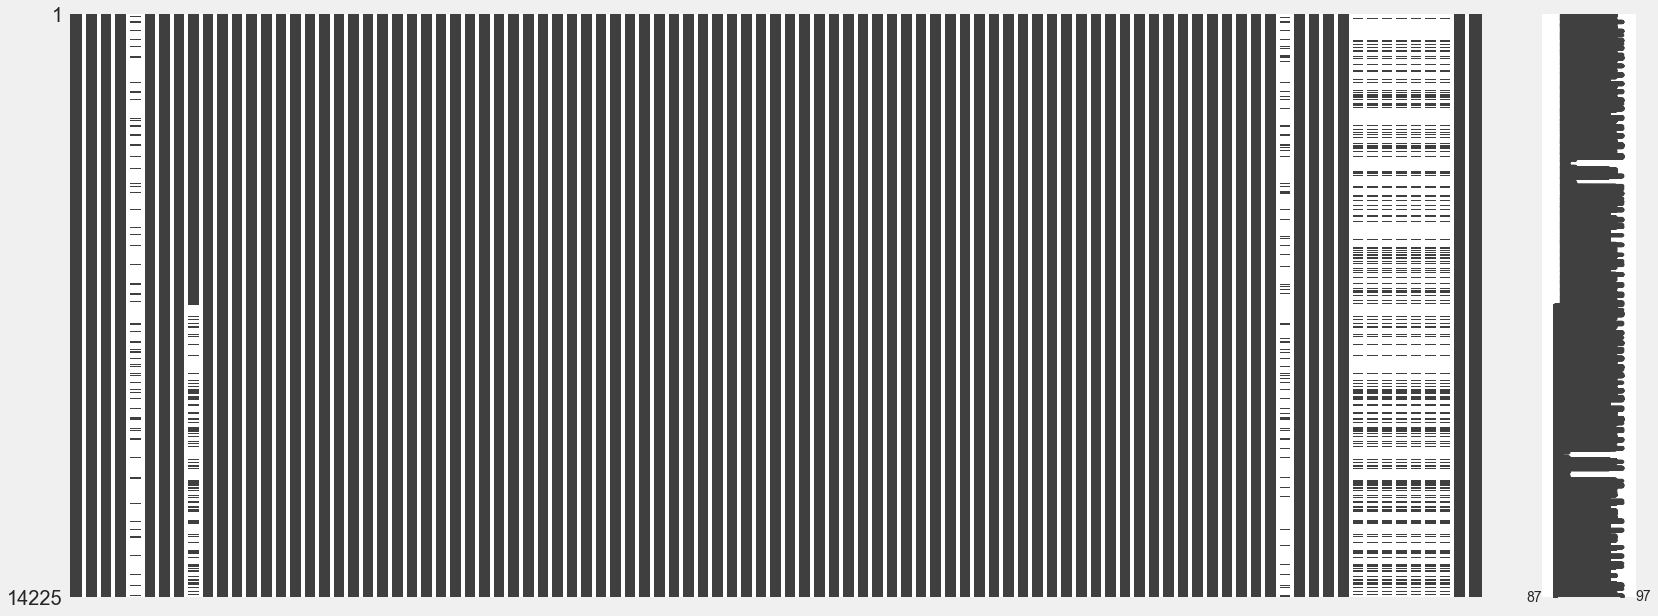

In [27]:
import missingno as msno
msno.matrix(df)

In [28]:
df['injury_status'] = df['injury_status'].apply(lambda x: 1 if x == "Questionable" else 0)

In [29]:
# Fill in nulls with a status of 'healthy'
df['injury_status'] = df['injury_status'].fillna(value = 'Healthy')
print(f'There are now {df.injury_status.nunique()} unique values in this column:')
df['injury_status'].unique()

There are now 2 unique values in this column:


array([0, 1])

In [30]:
df = df.drop([
    'InjuryStatus',
    
]
    , axis = 'columns')

In [31]:
df.head()

,PlayerID,week_id,Team,Position_x,injury_status,days_since_last_game,performance,performance_class,absolute_hours_displaced,GameKey,SeasonType,Season,GameDate,Week,Opponent,HomeOrAway,Number,Name,Position_y,PositionCategory,Played,Started,PassingAttempts,PassingCompletions,PassingYards,PassingCompletionPercentage,PassingYardsPerAttempt,PassingYardsPerCompletion,PassingTouchdowns,PassingInterceptions,PassingRating,PassingLong,PassingSacks,PassingSackYards,RushingAttempts,RushingYards,RushingYardsPerAttempt,RushingTouchdowns,RushingLong,ReceivingTargets,Receptions,ReceivingYards,ReceivingYardsPerReception,ReceivingTouchdowns,ReceivingLong,Fumbles,FumblesLost,PuntReturns,PuntReturnYards,PuntReturnTouchdowns,KickReturns,KickReturnYards,KickReturnTouchdowns,SoloTackles,AssistedTackles,TacklesForLoss,Sacks,SackYards,QuarterbackHits,PassesDefended,FumblesForced,FumblesRecovered,FumbleReturnTouchdowns,Interceptions,InterceptionReturnTouchdowns,FieldGoalsAttempted,FieldGoalsMade,ExtraPointsMade,TwoPointConversionPasses,TwoPointConversionRuns,TwoPointConversionReceptions,FantasyPoints,FantasyPointsPPR,FantasyPosition,PlayerGameID,ExtraPointsAttempted,FantasyPointsFanDuel,FieldGoalsMade0to19,FieldGoalsMade20to29,FieldGoalsMade30to39,FieldGoalsMade40to49,FieldGoalsMade50Plus,FantasyPointsDraftKings,TeamID,OpponentID,ScoreID,new_week_id,weather_temperature,weather_wind_mph_number,weather_wind_direction,weather_cloud_cover,weather_precipitation,weather_humidity,weather_detail,season_week,season_year
0,4314,2019_2,NE,QB,0,7.0,1.0,far overperformed,0.0,201910121.0,1.0,2019.0,2019-09-08T20:20:00,1.0,PIT,HOME,12.0,Tom Brady,QB,OFF,1.0,1.0,36.0,24.0,341.0,66.7,9.5,14.2,3.0,0.0,124.88,58.0,1.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.64,25.64,QB,990373823.0,0.0,25.64,0.0,0.0,0.0,0.0,0.0,28.64,21.0,28.0,16996.0,2019_2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2019
1,17920,2019_2,PHI,QB,0,7.0,0.0,far underperformed,0.0,201910126.0,1.0,2019.0,2019-09-08T13:00:00,1.0,WAS,HOME,11.0,Carson Wentz,QB,OFF,1.0,1.0,39.0,28.0,313.0,71.8,8.0,11.2,3.0,0.0,120.99,53.0,1.0,0.0,4.0,5.0,1.2,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.02,25.02,QB,990370737.0,0.0,25.02,0.0,0.0,0.0,0.0,0.0,28.02,26.0,35.0,16988.0,2019_2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2019
2,13320,2019_2,CAR,QB,0,4.0,0.0,far underperformed,0.0,201910105.0,1.0,2019.0,2019-09-08T13:00:00,1.0,LAR,HOME,1.0,Cam Newton,QB,OFF,1.0,1.0,38.0,25.0,239.0,65.8,6.3,9.6,0.0,1.0,72.15,17.0,3.0,23.0,3.0,-2.0,-0.7,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.36,5.36,QB,990370378.0,0.0,6.36,0.0,0.0,0.0,0.0,0.0,7.36,5.0,32.0,16989.0,2019_2,86.0,1.0,SouthEast,0.12,0.1,0.54,Drizzle,2,2019
3,18055,2019_2,DAL,QB,0,7.0,1.0,far overperformed,0.0,201910109.0,1.0,2019.0,2019-09-08T16:25:00,1.0,NYG,HOME,4.0,Dak Prescott,QB,OFF,1.0,1.0,32.0,25.0,405.0,78.1,12.7,16.2,4.0,0.0,158.33,62.0,0.0,0.0,4.0,12.0,3.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.40,33.40,QB,990371879.0,0.0,33.40,0.0,0.0,0.0,0.0,0.0,36.40,9.0,23.0,16993.0,2019_2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2019
4,18877,2019_2,CAR,RB,0,4.0,0.0,far underperformed,0.0,201910105.0,1.0,2019.0,2019-09-08T13:00:00,1.0,LAR,HOME,22.0,Christian McCaffrey,RB,OFF,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,19.0,128.0,6.7,2.0,23.0,11.0,10.0,81.0,8.1,0.0,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32.90,42.90,RB,990370478.0,0.0,37.90,0.0,0.0,0.0,0.0,0.0,45.90,5.0,32.0,16989.0,2019_2,86.0,1.0,SouthEast,0.12,0.1,0.54,Drizzle,2,2019


In [32]:
df.tail()

,PlayerID,week_id,Team,Position_x,injury_status,days_since_last_game,performance,performance_class,absolute_hours_displaced,GameKey,SeasonType,Season,GameDate,Week,Opponent,HomeOrAway,Number,Name,Position_y,PositionCategory,Played,Started,PassingAttempts,PassingCompletions,PassingYards,PassingCompletionPercentage,PassingYardsPerAttempt,PassingYardsPerCompletion,PassingTouchdowns,PassingInterceptions,PassingRating,PassingLong,PassingSacks,PassingSackYards,RushingAttempts,RushingYards,RushingYardsPerAttempt,RushingTouchdowns,RushingLong,ReceivingTargets,Receptions,ReceivingYards,ReceivingYardsPerReception,ReceivingTouchdowns,ReceivingLong,Fumbles,FumblesLost,PuntReturns,PuntReturnYards,PuntReturnTouchdowns,KickReturns,KickReturnYards,KickReturnTouchdowns,SoloTackles,AssistedTackles,TacklesForLoss,Sacks,SackYards,QuarterbackHits,PassesDefended,FumblesForced,FumblesRecovered,FumbleReturnTouchdowns,Interceptions,InterceptionReturnTouchdowns,FieldGoalsAttempted,FieldGoalsMade,ExtraPointsMade,TwoPointConversionPasses,TwoPointConversionRuns,TwoPointConversionReceptions,FantasyPoints,FantasyPointsPPR,FantasyPosition,PlayerGameID,ExtraPointsAttempted,FantasyPointsFanDuel,FieldGoalsMade0to19,FieldGoalsMade20to29,FieldGoalsMade30to39,FieldGoalsMade40to49,FieldGoalsMade50Plus,FantasyPointsDraftKings,TeamID,OpponentID,ScoreID,new_week_id,weather_temperature,weather_wind_mph_number,weather_wind_direction,weather_cloud_cover,weather_precipitation,weather_humidity,weather_detail,season_week,season_year
14555,22327,2020_17,LAR,WR,0,7.0,0.0,overperformed,NaN,202011630.0,1.0,2020.0,2020-12-27T16:25:00,16.0,SEA,AWAY,15.0,J.J. Koski,WR,OFF,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,WR,990575806.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32.0,30.0,17499.0,2020_17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17,2020
14558,22418,2020_17,TEN,TE,0,7.0,0.0,overperformed,0.0,202011612.0,1.0,2020.0,2020-12-27T20:20:00,16.0,GB,AWAY,89.0,Tommy Hudson,TE,OFF,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TE,990576622.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.0,12.0,17501.0,2020_17,72.0,0.0,No wind,0.5,0.0,0.44,DOME,17,2020
14559,22456,2020_17,SF,TE,0,8.0,0.0,overperformed,NaN,202011601.0,1.0,2020.0,2020-12-26T16:30:00,16.0,ARI,AWAY,83.0,Chase Harrell,TE,OFF,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TE,990573885.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.0,1.0,17491.0,2020_17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17,2020
14560,21295,2020_17,LAR,WR,0,7.0,1.0,overperformed,NaN,202011630.0,1.0,2020.0,2020-12-27T16:25:00,16.0,SEA,AWAY,14.0,Nsimba Webster,WR,OFF,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,10.0,0.0,3.0,62.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,WR,990575792.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32.0,30.0,17499.0,2020_17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17,2020
14561,19763,2020_17,SF,QB,0,8.0,1.0,overperformed,NaN,202011601.0,1.0,2020.0,2020-12-26T16:30:00,16.0,ARI,AWAY,2.0,Josh Rosen,QB,OFF,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,QB,990573858.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.0,1.0,17491.0,2020_17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17,2020


In [ ]:
df.describe()

### Preparing the data
<a id='preparing_data_cell'></a>

In [ ]:
# Split dataframe into two dataframes: X will have all but target, y will have target
X = df.drop('performance', axis = 1)
y = df['performance']

In [ ]:
labels = target['performance_class'].unique()
labels

In [ ]:
target = target[target['performance_class'] != None]

In [ ]:
target = target['performance_class']

In [ ]:
y

In [ ]:
visualizer = ClassBalance(labels=['far overperformed', 'far underperformed', 'overperformed',
       'underperformed'])

visualizer.fit(target) # Fit the data to the visualizer
visualizer.show() # Finalize and render the figure
plt.show()

In [ ]:
# Instantiate the visualizer
visualizer = ClassBalance(labels=['Overperform', 'Underperform'])

visualizer.fit(y) # Fit the data to the visualizer
visualizer.show() # Finalize and render the figure
plt.show()

## Global Machine Learning Model
<a id='global_model_cell'></a>
Explain concept

### Model Selection
<a id='model_selection_cell'></a>

#### Selecting Columns 
<a id='column_selection_cell'></a>
From the [sklearn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.compose.make_column_selector.html):
> Create a callable to select columns to be used with ColumnTransformer.   
>   
>```make_column_selector``` can select columns based on datatype or the columns name with a regex. When using multiple selection criteria, all criteria must match for a column to be selected.

In [ ]:
X_train, X_test, y_train, y_test = tts(X, y, test_size=.2)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

In [ ]:
categorical = make_column_selector(dtype_include=np.object)
numeric = make_column_selector(dtype_include=np.int64)
numeric2 = make_column_selector(dtype_include=np.float64)

#### Selecting models to score
<a id='model_scoring_selection_cell'></a>

In [ ]:
# list of models to use
models = [
    SVC(gamma='auto'),
    NuSVC(gamma='auto'),
    LinearSVC(),
    SGDClassifier(max_iter=100, tol=1e-3),
    KNeighborsClassifier(),
    LogisticRegression(solver='lbfgs'),
    LogisticRegressionCV(cv=3, max_iter=100),
    BaggingClassifier(),
    ExtraTreesClassifier(n_estimators=300),
    RandomForestClassifier(n_estimators=300)
]

In [ ]:
# function to score models
def score_model(X, y, estimator, **kwargs):
    """
    Test various estimators.
    Input: 
    """
    y = LabelEncoder().fit_transform(y)
    model = Pipeline([
    ("columns", ColumnTransformer([
        ('onehot', OneHotEncoder(), categorical),
        ('scalar', RobustScaler(), numeric),
        ('scalar2', RobustScaler(), numeric2),
    ], remainder='drop')),
        ("imputer",SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('estimator', estimator)
])

    # Instantiate the classification model and visualizer
    model.fit(X, y, **kwargs)

    expected  = y
    predicted = model.predict(X)

    # Compute and return F1 (harmonic mean of precision and recall)
    print("F1 SCORE {}: {}".format(estimator.__class__.__name__, f1_score(expected, predicted)))

In [ ]:
# function to visualize models
def visualize_model(X, y, estimator, **kwargs):
    """
    
    """
    y = LabelEncoder().fit_transform(y)
    model = Pipeline([
    ("columns", ColumnTransformer([
        ('onehot', OneHotEncoder(), categorical),
        ('scalar', RobustScaler(), numeric),
        ('scalar2', RobustScaler(), numeric2),
    ], remainder='drop')),
    ('estimator', estimator)
])

    # Instantiate the classification model and visualizer
    visualizer = ClassificationReport(
        model, classes=['Underperformed', 'Overperformed'],
        cmap="YlGn", size=(600, 360), **kwargs
    )
    visualizer.fit(X, y)
    visualizer.score(X, y)
    visualizer.show()

In [ ]:
X['Positionsition'].unique()

In [ ]:
y.count()

#### Scoring selected models
<a id='scoring_models_cell'></a>

In [ ]:
# iterate through list of models through both functions defined above
# Use X and y dataframes first, which contain all of the data
for model in models:
    score_model(X, y, model)
    visualize_model(X, y, model)

In [ ]:
# iterate through list of models through both functions defined above
# Use X and y dataframes first, which contain all of the data
for model in models:
    score_model(X_train, y_train, model)
    visualize_model(X_test, y_test, model)

## Hyperparameter Tuning
<a id='hyperparameter_tuning_cell'></a>

## Title
<a id='header_cell'></a>